## Scenario - Robots, after they have replaced children in a chinese warehouse :)
A growing e-commerce company is building a new warehouse, and the company would like all of the picking operations in the new warehouse to be performed by warehouse robots.
* In the context of e-commerce warehousing, “picking” is the task of gathering individual items from various locations in the warehouse in order to fulfill customer orders.

After picking items from the shelves, the robots must bring the items to a specific location within the warehouse where the items can be packaged for shipping.

In order to ensure maximum efficiency and productivity, the robots will need to learn the shortest path between the item packaging area and all other locations within the warehouse where the robots are allowed to travel.
* We will use Q-learning to accomplish this task!

#### Import Required Libraries

In [ ]:
#import libraries
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Define the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.
#### States
The states in the environment are all of the possible locations within the warehouse. Some of these locations are for storing items (**black squares**), while other locations are aisles that the robot can use to travel throughout the warehouse (**white squares**). The **green square** indicates the item packaging and shipping area.

The black and green squares are **terminal states**!

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map.png)

The AI agent's goal is to learn the shortest path between the item packaging area and all of the other locations in the warehouse where the robot is allowed to travel.

As shown in the image above, there are 121 possible states (locations) within the warehouse. These states are arranged in a grid containing 11 rows and 11 columns. Each location can hence be identified by its row and column index.

In [ ]:
#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((environment_rows, environment_columns, 4))

#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the item storage locations (e.g., shelves)!


In [ ]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#### Rewards
The last component of the environment that we need to define are the **rewards**.

To help the AI agent learn, each state (location) in the warehouse is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

Negative rewards (i.e., **punishments**) are used for all states except the goal.
* This encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*!

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map-rewards.png)

To maximize its cumulative rewards (by minimizing its cumulative punishments), the AI agent will need find the shortest paths between the item packaging area (green square) and all of the other locations in the warehouse where the robot is allowed to travel (white squares). The agent will also need to learn to avoid crashing into any of the item storage locations (black squares)!

In [ ]:
#Create a 2D numpy array to hold the rewards for each state.
#The array contains 11 rows and 11 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), -100.)
rewards[0, 5] = 100. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(1, 10):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1.

#print rewards matrix
for row in rewards:
  print(row)

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]


## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths between the item packaging area and all other locations in the warehouse where the robot is allowed to travel, while simultaneously avoiding crashing into any of the item storage locations!

#### Define Helper Functions

In [ ]:
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    print("Can't start there")
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#### Train the AI Agent using Q-Learning



In [ ]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
  while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)

    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

Training complete!


## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the warehouse where the robot is allowed to travel and the item packaging area.

![warehouse map](https://www.danielsoper.com/teaching/img/08-warehouse-map.png)

Run the code cell below to try a few different starting locations!

In [ ]:
#display a few shortest paths
print(get_shortest_path(3, 9)) #starting at row 3, column 9
print(get_shortest_path(5, 0)) #starting at row 5, column 0
print(get_shortest_path(9, 5)) #starting at row 9, column 5

[[3, 9], [2, 9], [1, 9], [1, 8], [1, 7], [1, 6], [1, 5], [0, 5]]
[[5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
[[9, 5], [9, 4], [9, 3], [8, 3], [7, 3], [7, 4], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]


#### Finally...
It's great that our robot can automatically take the shortest path from any 'legal' location in the warehouse to the item packaging area. **But what about the opposite scenario?**

Put differently, our robot can currently deliver an item from anywhere in the warehouse ***to*** the packaging area, but after it delivers the item, it will need to travel ***from*** the packaging area to another location in the warehouse to pick up the next item!

Don't worry -- this problem is easily solved simply by ***reversing the order of the shortest path***.

Run the code cell below to see an example:

In [ ]:
#display an example of reversed shortest path
path = get_shortest_path(5, 2) #go to row 5, column 2
path.reverse()
print(path)

[[0, 5], [1, 5], [1, 6], [1, 7], [2, 7], [3, 7], [4, 7], [5, 7], [5, 6], [5, 5], [5, 4], [5, 3], [5, 2]]


In [ ]:


def visualize_map(grid, path):
    # Create a figure and axis
    if (path == []):
      return

    fig, ax = plt.subplots()

    # Create a colormap for the grid (optional)
    cmap = LinearSegmentedColormap.from_list('black_white', ['black', 'white'])

    # Plot the grid
    ax.imshow(grid, cmap=cmap)

    # Plot the path as a series of lines
    path_x, path_y = zip(*path)  # Unzip the path coordinates
    ax.plot(path_x, path_y, marker='o', color='b')
    ax.plot(path_x[0],path_y[0], marker = 's' , color = 'red')

    # Show the plot
    plt.show()

def reverse_coordinates(path):

    for i in path:
      i[0],i[1] = i[1],i[0]

    return path

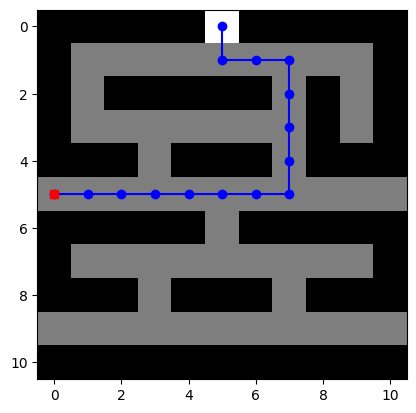

In [ ]:
visualize_map(rewards,reverse_coordinates(get_shortest_path(5,0)))